In [91]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.initializers import Constant
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from konlpy.tag import Mecab
from collections import Counter

'''
Counter 생성자는 여러 형태의 데이터를 인자로 받는데요. 먼저 중복된 데이터가 저장된 배열을 
인자로 넘기면 각 원소가 몇 번씩 나오는지가 저장된 객체를 얻게 됩니다
'''

import konlpy
import gensim

from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors

In [92]:
train_data = pd.read_table('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt')
test_data = pd.read_table('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt')

In [93]:
print(train_data.head(),'\n')
print(test_data.head())

         id                                           document  label
0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1 

        id                                           document  label
0  6270596                                                굳 ㅋ      1
1  9274899                               GDNTOPCLASSINTHECLUB      0
2  8544678             뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아      0
3  6825595                   지루하지는 않은데 완전 막장임... 돈주고 보기에는....      0
4  6723715  3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??      0


In [94]:

tokenizer = Mecab() # 인풋으로 입력되는 문장을 작은 단위로 쪼개주는 형태소 분석
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']


In [95]:
def load_data(train_data, test_data, num_words=10000):
    # [[YOUR CODE]]

    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화 # morphs : 형태소 추출
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist() # 2차원 배열을 1차원 배열로 전환
    counter = Counter(words)
    counter = counter.most_common(10000-4) #요소를 세어, 최빈값 n개를 반환합니다. (리스트에 담긴 튜플형태로) [(1,9),(2,1)] => 1,9개  2,1개   
    vocab = ['', '', '', ''] + [key for key, _ in counter] # 'pad' , 'bos', 'unk', 'unused'
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
    
X, y, X_test, y_test, word_to_index = load_data(train_data, test_data)

# X data 사이즈 난리났다

In [97]:
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2
#word_to_index["<UNUSED>"] = 3

In [98]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [99]:
print(index_to_word[0], index_to_word[1], index_to_word[2])
print(index_to_word)

<PAD> <BOS> <UNK>
{3: '', 4: '.', 5: '영화', 6: '다', 7: '고', 8: '하', 9: '을', 10: '보', 11: '..', 12: '게', 13: ',', 14: '!', 15: '지', 16: '있', 17: '없', 18: '?', 19: '좋', 20: '나', 21: '었', 22: '만', 23: '는데', 24: '너무', 25: '봤', 26: '적', 27: '안', 28: '정말', 29: '로', 30: '음', 31: '것', 32: '아', 33: '네요', 34: '재밌', 35: '어', 36: '같', 37: '점', 38: '지만', 39: '진짜', 40: '했', 41: '에서', 42: '기', 43: '네', 44: '않', 45: '거', 46: '았', 47: '수', 48: '되', 49: '면', 50: 'ㅋㅋ', 51: '말', 52: '연기', 53: '인', 54: '주', 55: '내', 56: '최고', 57: '~', 58: '평점', 59: '이런', 60: '던', 61: '어요', 62: '할', 63: '왜', 64: '겠', 65: '1', 66: '스토리', 67: '해', 68: '습니다', 69: 'ㅋㅋㅋ', 70: '...', 71: '드라마', 72: '생각', 73: '아니', 74: '더', 75: '그', 76: '싶', 77: '사람', 78: '듯', 79: '때', 80: '감동', 81: '함', 82: '배우', 83: '본', 84: '까지', 85: '뭐', 86: '알', 87: '만들', 88: '내용', 89: '볼', 90: '감독', 91: '보다', 92: '라', 93: '그냥', 94: '재미', 95: '시간', 96: '지루', 97: '중', 98: '재미있', 99: '년', 100: '10', 101: '였', 102: '잼', 103: '사랑', 104: '못', 105: '냐', 106: '재미없', 

In [100]:
index_to_word = {index:word for word, index in word_to_index.items()}
index_to_word.keys()

dict_keys([3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221

In [101]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [102]:
for i in range(3) :
    print(get_decoded_sentence(X[i],index_to_word))

더 빙 . . 진짜 짜증 나 네요 목소리
. .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나
재 


* pad_sequences를 통해 데이터셋 상의 문장의 길이를 통일
* 문장 최대 길이 maxlen의 값 설정도 전체 모델 성능에 영향
* 적절한 값을 찾기 위해서는 전체 데이터셋의 분포를 확인

In [103]:
total_data_text = list(X) + list(X)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.98170773419436
문장길이 최대 :  116
문장길이 표준편차 :  12.82473766384545
pad_sequences maxlen :  41
전체 문장의 0.9341711017772366%가 maxlen 설정값 이내에 포함됩니다. 


* 마지막 입력이 최종state에 영향을 많이 끼치기에 padding은 앞쪽

In [104]:
# padding
X = tf.keras.preprocessing.sequence.pad_sequences(X,
                                                  value=word_to_index["<PAD>"],
                                                  padding='pre',
                                                  maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                  value=word_to_index["<PAD>"],
                                                  padding='pre',
                                                  maxlen=maxlen)

print(X.shape)

(146182, 41)


# RNN

In [105]:
vocab_size = 10000 # 어휘 사전의 크기입니다
word_vector_dim = 25  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model_RNN = tf.keras.Sequential()
model_RNN.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_RNN.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_RNN.add(tf.keras.layers.Dense(16, activation='relu'))
model_RNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_RNN.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, None, 25)          250000    
_________________________________________________________________
lstm_14 (LSTM)               (None, 8)                 1088      
_________________________________________________________________
dense_32 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 17        
Total params: 251,249
Trainable params: 251,249
Non-trainable params: 0
_________________________________________________________________


# CNN

In [106]:
model_CNN = tf.keras.Sequential()
model_CNN.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_CNN.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(tf.keras.layers.MaxPooling1D(5))
model_CNN.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(tf.keras.layers.GlobalMaxPooling1D())
model_CNN.add(tf.keras.layers.Dense(8, activation='relu'))
model_CNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_CNN.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, None, 25)          250000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          2816      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_35 (Dense)             (None, 1)               

# GlobalMaxPooling레이어 하나만 사용하는 방법

In [107]:
model_maxpool = tf.keras.Sequential()
model_maxpool.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_maxpool.add(tf.keras.layers.GlobalMaxPooling1D())
model_maxpool.add(tf.keras.layers.Dense(8, activation='relu'))
model_maxpool.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_maxpool.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, None, 25)          250000    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 25)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 8)                 208       
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 9         
Total params: 250,217
Trainable params: 250,217
Non-trainable params: 0
_________________________________________________________________


In [108]:
models = [model_RNN, model_CNN, model_maxpool]

In [109]:
def compile_model(model, epochs) :
    model.compile(optimizer = 'adam',
                 loss = 'binary_crossentropy',
                 metrics = ['accuracy'])
    history = model.fit(X_train,
                       y_train,
                       epochs = epochs,
                       batch_size =512,
                       validation_data = (X_val, y_val),
                       verbose =1)
    
    return history

In [110]:
#validation set 설정

state = 100

X_train, X_val = train_test_split(X,train_size = 0.8, random_state = state)
y_train, y_val = train_test_split(y, train_size = 0.8,random_state = state)

print(X_train.shape)
print(y_train.shape)

(116945, 41)
(116945,)


In [111]:
# 학습 

epochs = 10
models_history = []

for model in models :
    print(model)
    models_history.append(compile_model(model, epochs))
    print("-----------------------------------------------------------")

Epoch 1/10
229/229 [==============================] - 3s 8ms/step - loss: 0.4927 - accuracy: 0.7732 - val_loss: 0.3672 - val_accuracy: 0.8417
Epoch 2/10
229/229 [==============================] - 1s 6ms/step - loss: 0.3370 - accuracy: 0.8579 - val_loss: 0.3550 - val_accuracy: 0.8455
Epoch 3/10
229/229 [==============================] - 1s 6ms/step - loss: 0.3142 - accuracy: 0.8687 - val_loss: 0.3584 - val_accuracy: 0.8453
Epoch 4/10
229/229 [==============================] - 1s 6ms/step - loss: 0.3015 - accuracy: 0.8753 - val_loss: 0.3533 - val_accuracy: 0.8489
Epoch 5/10
229/229 [==============================] - 1s 6ms/step - loss: 0.2901 - accuracy: 0.8808 - val_loss: 0.3526 - val_accuracy: 0.8493
Epoch 6/10
229/229 [==============================] - 1s 6ms/step - loss: 0.2793 - accuracy: 0.8859 - val_loss: 0.3532 - val_accuracy: 0.8500
Epoch 7/10
229/229 [==============================] - 1s 6ms/step - loss: 0.2688 - accuracy: 0.8902 - val_loss: 0.3615 - val_accuracy: 0.8501
Epoch 

In [112]:
# test 평가

results =[]

for mode in models :
    print(mode)
    results.append(mode.evaluate(X_test, y_test, verbose = 2))
    print("---------------------------------------------------")

1537/1537 - 3s - loss: 0.3879 - accuracy: 0.8442
---------------------------------------------------
1537/1537 - 3s - loss: 0.6285 - accuracy: 0.8313
---------------------------------------------------
1537/1537 - 2s - loss: 0.4301 - accuracy: 0.8339
---------------------------------------------------


In [113]:
def figure(models_history) :
    history_dict = models_history.history
    
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)
    
    fig , (ax1,ax2) = plt.subplots(1,2, figsize =(10,10))

    
    ax1.plot(epochs, loss, 'b', label='Training loss')
    ax1.plot(epochs, val_loss, 'r', label='Validation loss')
    ax1.legend()
    
    ax2.plot(epochs, loss, 'b', label='Training loss')
    ax2.plot(epochs, val_loss, 'r', label='Validation loss')
    ax2.legend()

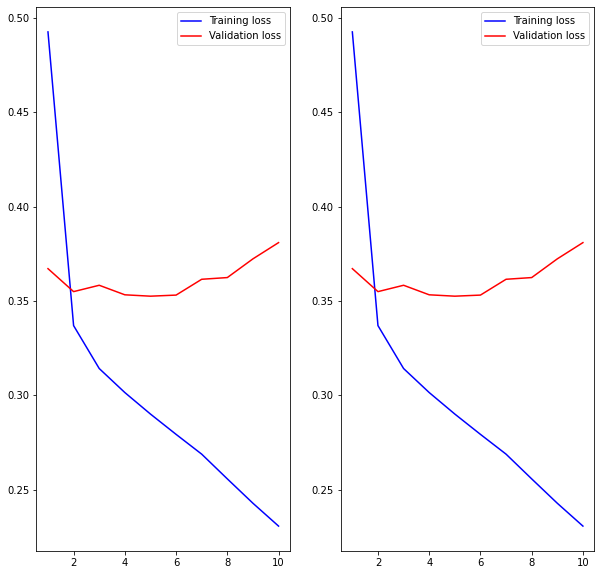

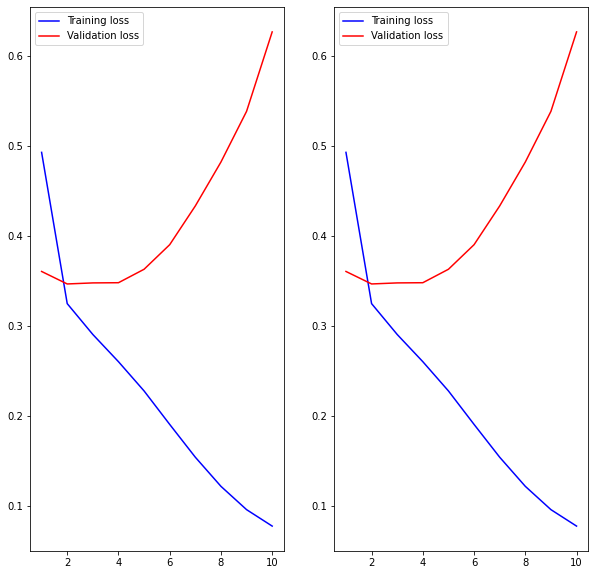

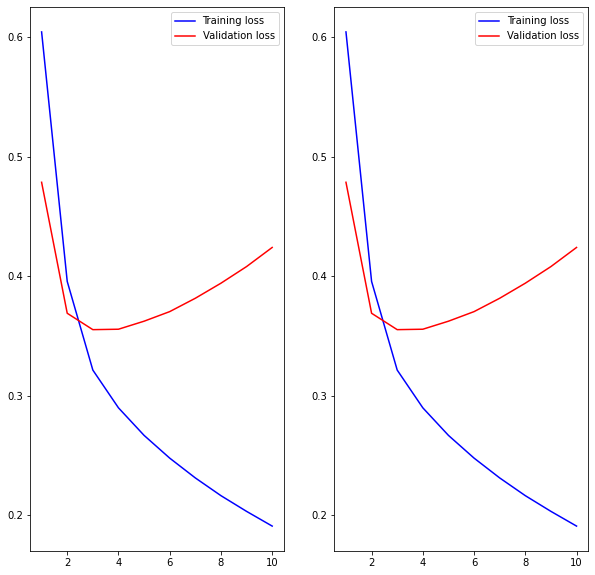

In [114]:
for i, history in enumerate(models_history) :
    figure(history)

In [115]:
def get_weights(models) :
    embedding_layer = model.layers[0]
    weights = embedding_layer.get_weights()[0]
    return weights.shape    # shape: (vocab_size, embedding_dim)

In [116]:
for i, model in enumerate(models):
    print(get_weights(model))

(10000, 25)
(10000, 25)
(10000, 25)


In [117]:
def save_weights(index, model) :
    word2vec_file_path = os.getenv('HOME')+f'/aiffel/sentiment_classification/data/word2vec_{index}.txt'
    f = open(word2vec_file_path, 'w')
    f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  
        # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

    # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
    vectors = model.get_weights()[0]
    for i in range(4,vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
            
    f.close()
    print("saved")

In [118]:
for index, model in enumerate(models):
    save_weights(index, model)

saved
saved
saved


In [119]:
# word vector로 사용하기
word_vectors_list = []

for index in range(3):
    word_vectors_list.append(Word2VecKeyedVectors.load_word2vec_format(os.getenv('HOME')+f'/aiffel/sentiment_classification/data/word2vec_{index}.txt', binary=False))

for i, word_vectors in enumerate(word_vectors_list):
    word = "잠"
    vector = word_vectors[word]
    print("===========================")
    for j in word_vectors.similar_by_word(word):
        print(j)

('기술력', 0.9505813121795654)
('지루', 0.9503684043884277)
('베꼈', 0.9501311779022217)
('죄송', 0.948097825050354)
('환영', 0.9463011622428894)
('제로', 0.9453192353248596)
('뻥튀기', 0.943199872970581)
('못생겼', 0.939775288105011)
('진부', 0.9381905794143677)
('억지', 0.9380639791488647)
('이끄', 0.8380491137504578)
('뭔', 0.8235778212547302)
('졸업', 0.820634663105011)
('어필', 0.817590057849884)
('모야', 0.8175312876701355)
('별로', 0.8108929395675659)
('미확인', 0.7988772988319397)
('장기', 0.7965967059135437)
('허술', 0.793798565864563)
('짜집', 0.7890278697013855)
('파티', 0.8568925261497498)
('-_', 0.8082500100135803)
('폭동', 0.8082266449928284)
('저렴', 0.8081615567207336)
('냐', 0.8074337244033813)
('..-_-', 0.8068477511405945)
('저주', 0.7985106110572815)
('퇴보', 0.7935155034065247)
('맞먹', 0.7904488444328308)
('솔로', 0.7895365953445435)


* 잠과 솔로는 무슨 관계야,,, ㅡ_ㅡ
* 표정은 맘에 드네 너무 귀엽다
* 잠이랑 못생김이 관계가 있다?!?!?!? 헉!

In [120]:
# word2vec 가져오기
#word2vec_path = os.getenv('HOME')+"/aiffel/sentiment_classification/data/word2vec_ko.model" # 얘 왜 안돼....
word2vec_path = os.getenv('HOME') + "/data/word2vec_ko.model" # 얘랑 무슨 차이야
word_vectors = Word2VecKeyedVectors.load(word2vec_path)
vector = word_vectors.wv["잠"]

In [121]:
word_vectors.wv.similar_by_word("잠")

[('낮잠', 0.7209728956222534),
 ('깨어나', 0.6985119581222534),
 ('늦잠', 0.6658555865287781),
 ('한숨', 0.6528148055076599),
 ('하룻밤', 0.6330604553222656),
 ('노숙', 0.6213618516921997),
 ('도망가', 0.6158702373504639),
 ('깨어났', 0.613922655582428),
 ('겨울잠', 0.6007667779922485),
 ('감방', 0.5990805625915527)]

* 도망가!!! 매우 맘에 든다.
* 잠 유사도 잘 나온다
* 감방과 잠,,, 잠자면 감방가? 이건 아니지


* 확실히 이전에 비해서 더 잘 나오긴하네


In [122]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

# LSTM : 64 , epoch : 3, batch :64

In [143]:
#vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
#word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(64))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, None, 100)         1000000   
_________________________________________________________________
lstm_18 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_44 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 65        
Total params: 1,046,465
Trainable params: 1,046,465
Non-trainable params: 0
_________________________________________________________________


In [144]:
# 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=3  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

historys = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=2)

Epoch 1/3
1828/1828 - 11s - loss: 0.3717 - accuracy: 0.8321 - val_loss: 0.3292 - val_accuracy: 0.8576
Epoch 2/3
1828/1828 - 9s - loss: 0.2838 - accuracy: 0.8785 - val_loss: 0.3186 - val_accuracy: 0.8643
Epoch 3/3
1828/1828 - 9s - loss: 0.2411 - accuracy: 0.8994 - val_loss: 0.3321 - val_accuracy: 0.8634


In [147]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=5)

print(results)

[0.3338290750980377, 0.8610167503356934]


* 86% 행복하다

# LSTM : 128 , EPOCHS : 1 , BATCH : 128

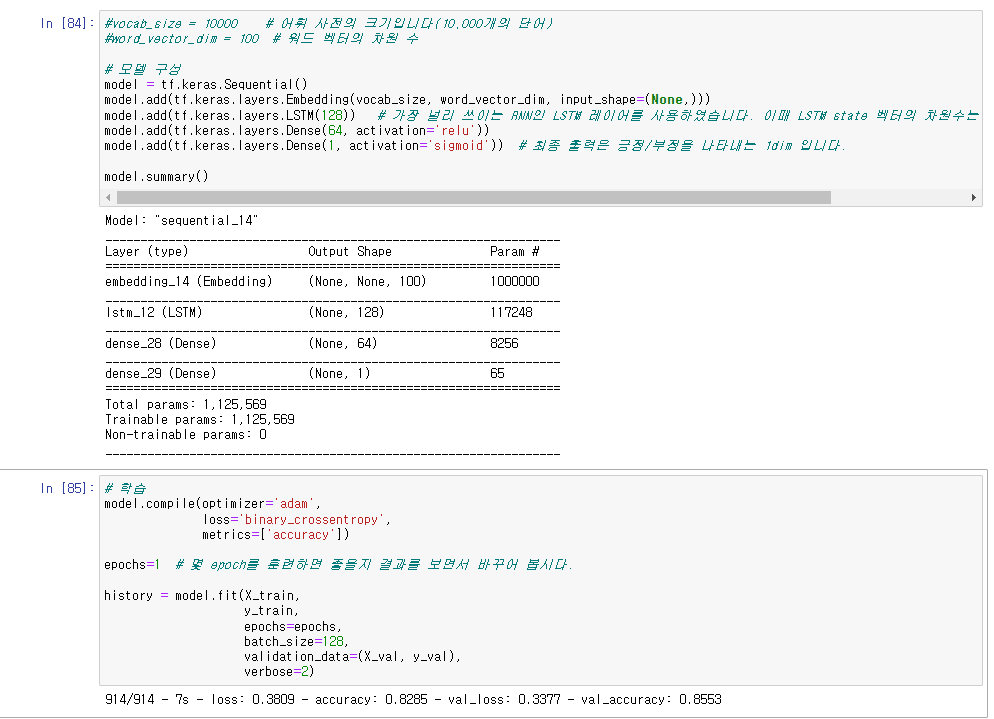

# LSTM(8) , EPOCH 4, BATCH : 256 

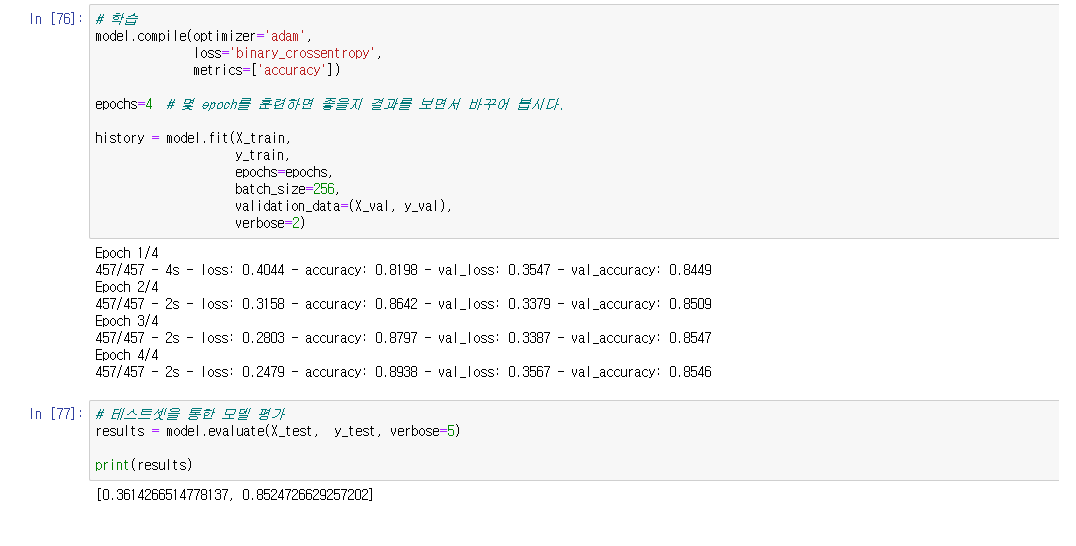

#  LSTM : 64,  EPOCH:1 BATCH :64

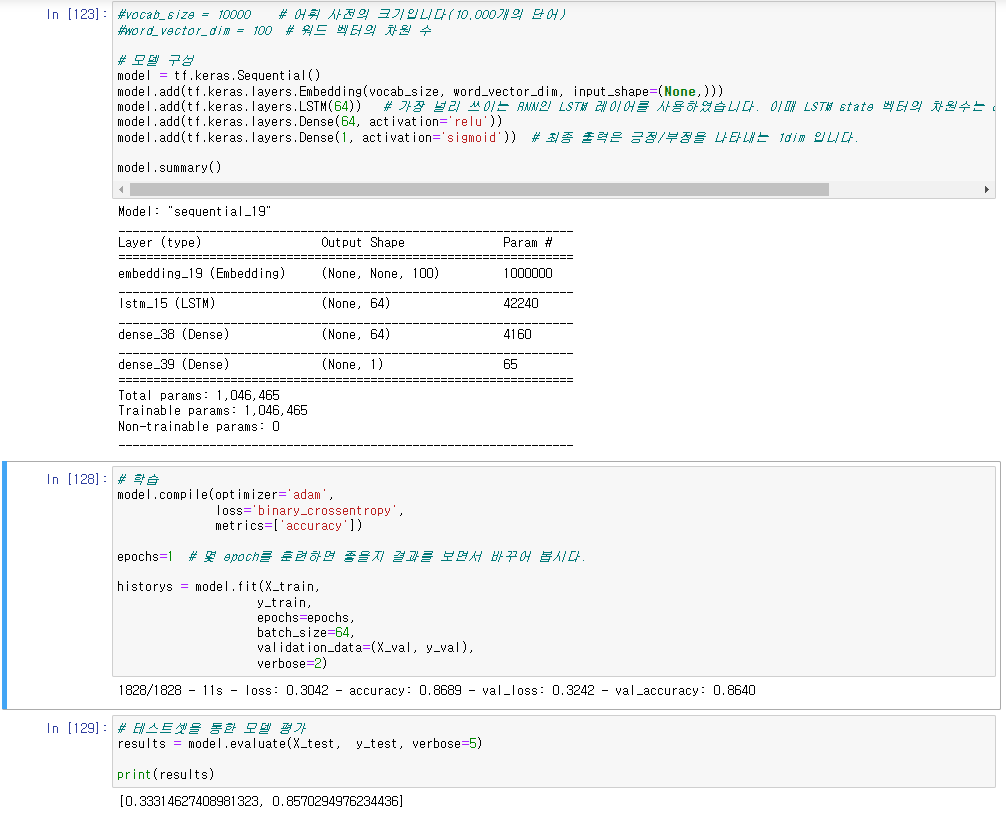

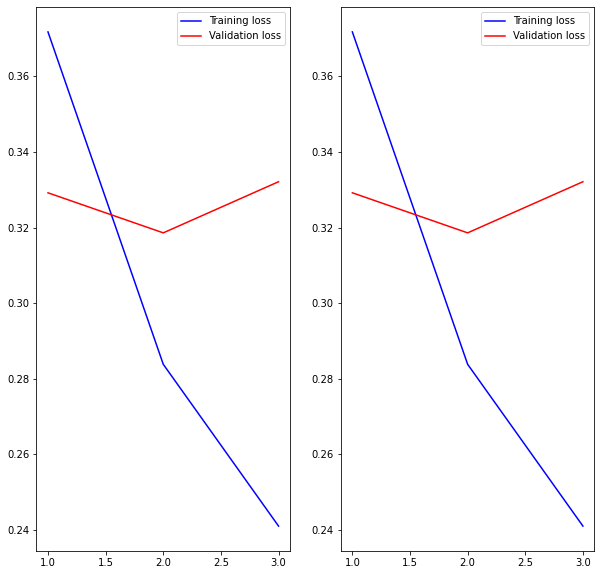

In [146]:
figure(historys)

# 회고


* LSTM 벡터 차원수랑  batch사이즈는 반비례해야지 성능이 잘 나온다.
* 굳이 LSTM이 많이 커지면 매우 epoch를 작게해서 overfitting 방지 해야한다.
* epoch 를 1로 하면 figure 값 나오지 않으니 고민 하지말고 패스, 당연하지만 고민 오래함 
* train, validation 크기는 0.5:0.5 보다는 확실히 train : validation = 0.8 :0.2가 훨씬 잘나옴 ->얘는 더 고민해 보자 
* 3번에 "unused" 넣으면 중간중간에 "unused" 출력됨 ->이건 설정을 " " 이 맞다
* validation 과 test 가 같게 두면 성능이 오르나? -> 추후 확인 필요




